# Stackoverflow Tag Predictor

In [54]:
# Libraries

import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import nltk
# nltk.download('punkt')
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# from skmultilearn.adapt import mlknn
# from skmultilearn.problem_transform import ClassifierChain
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# <h1>1. Business Problem </h1>

## Description

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### Source / useful links

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

# Data

## Data overview

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

### Example Datapoint:

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

# Mapping Real World problem to Machine Learning problem

## Type of Machine Learning problem

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

### Performance Metric:

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

# Exploratory Data Analysis

## Data Loading and Cleaning

### Using Pandas with SQLITE to load

In [7]:
###Creating db file from csv
###Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
#   start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
#    print("Time taken to run this cell :", datetime.now() - start)

In [8]:
if os.path.isfile('train.db'):
    #start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    # Always remember to close the database
    # num_rows['count(*)'].values[0] -> 6034196
    con.close()
   # print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

### Checking for Duplicates

In [9]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    #start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    #print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

In [10]:
# print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")
# number of duplicate questions : 1827881 ( 30.2920389063 % )

In [11]:
# number of times each question appeared in our database
# df_no_dup.cnt_dup.value_counts() ->
    # 1    2656284
    # 2    1272336
    # 3     277575
    # 4         90
    # 5         25
    # 6          5
    # Name: cnt_dup, dtype: int64

In [12]:
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question

# distribution of number of tags per question
# df_no_dup.tag_count.value_counts() ->

    # 3    1206157
    # 2    1111706
    # 4     814996
    # 1     568298
    # 5     505158
    # Name: tag_count, dtype: int64

In [13]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [14]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:01:13.789734


### Analysis of Tags

In [17]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])
# tag_dtm.shape() -> (4206314, 42048)

In [18]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### Number of times tag appeared

In [19]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [20]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [21]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

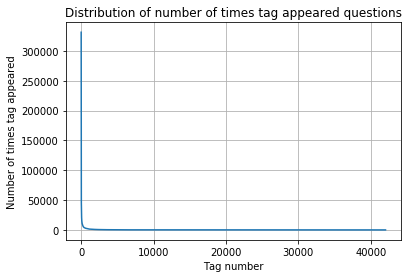

In [22]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

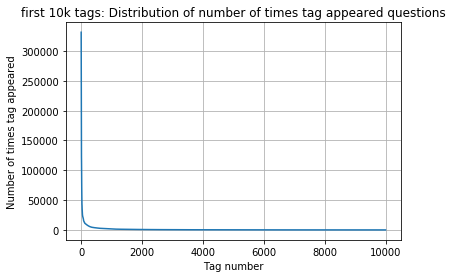

In [24]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

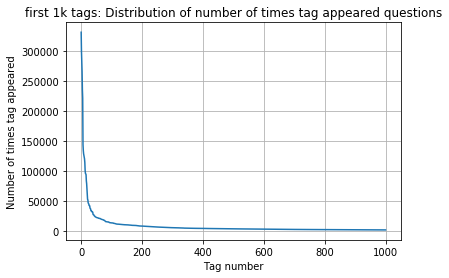

In [25]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

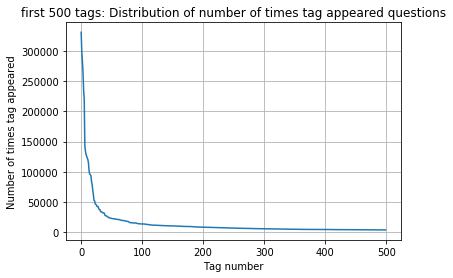

In [26]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

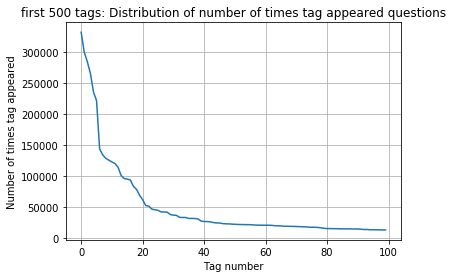

In [29]:
plt.plot(tag_counts[0:100])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
# print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

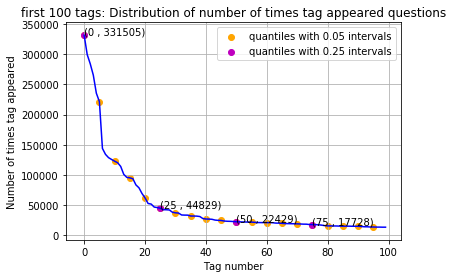

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [27]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [30]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### Tags per question

In [31]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [32]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


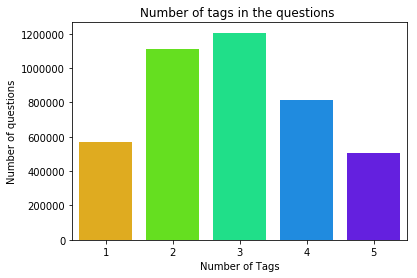

In [35]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### Most Frequent Tags

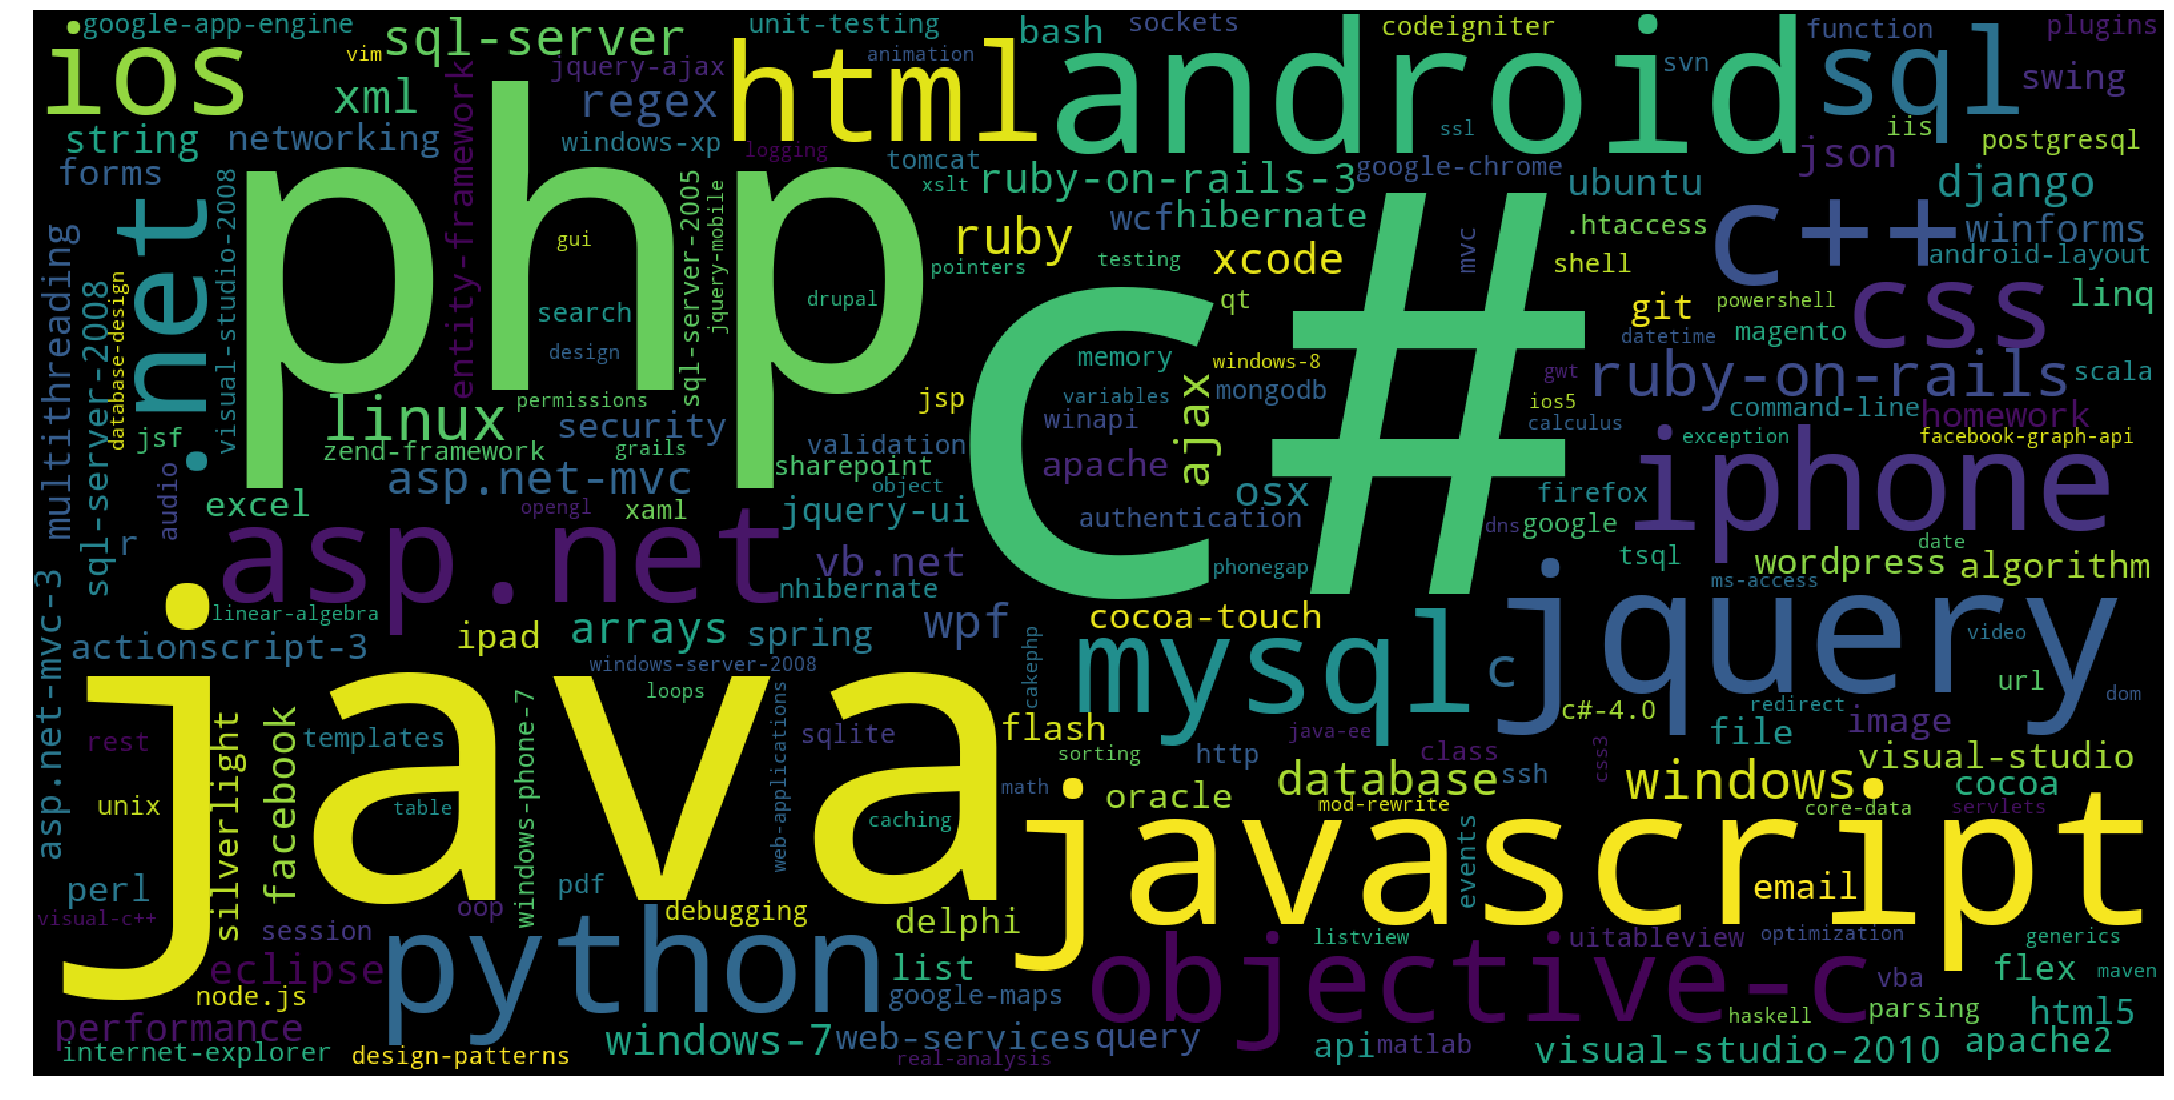

Time taken to run this cell : 0:00:05.765948


In [36]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "android" are some of the most frequent tags.

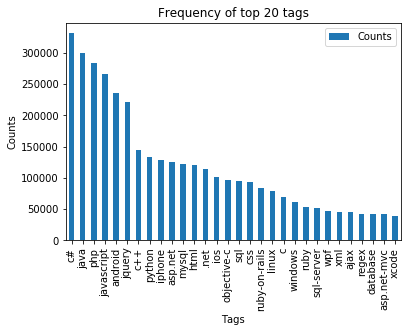

In [37]:
# Top 20 tags

i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

In [5]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [6]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the database:
QuestionsProcessed


### Modeling with less data points (0.5M data points) and more weight to title and 500 tags only

In [7]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the database:
QuestionsProcessed


In [8]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the database:
QuestionsProcessed
Cleared All the rows


### Preprocessing of questions

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [9]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:22:18.214845


In [10]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

### Sample questions after preprocessing of data

In [11]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

In [2]:
# to directly load the data in jupyter notebook -> curlwget: googlechrome extension
# Titlemoreweight.db 

!wget --header="Host: doc-08-2o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/drive/folders/149ZLCNqL4WBdp-7Y3eHxcMHHhVvIWRSW" --header="Cookie: AUTH_gartq2bjirar9r090gc8ecqcac24ouqd_nonce=v4ir9jtsd29n0; NID=146=nBWpj7JcBqdMqbaoVrleD0MxDs5wP4nGTM0hUmD2wQ50nMSDQvyL8CImN6XOynxscwkL9_HLWSREr2cQ1W3tG3EzwBi4-AWOCwE5h7TYqCFu_d4VVwNVCcrK1CFRqjAvKNtkEkF5RQQmKQHVsQfuQBSJ8ZGF7fKZzSKncDwy_iw" --header="Connection: keep-alive" "https://doc-08-2o-docs.googleusercontent.com/docs/securesc/pesbqquiuvf4tths9a3st80t8r13q66i/pgqs4h666feqf8la1br30afb8f8st3su/1549368000000/06629147635963609455/13992145837893218268/1S_P2E4DxDAwd15YFMgwlvT3NVlfeYqXS?e=download&nonce=v4ir9jtsd29n0&user=13992145837893218268&hash=chfv0isuv4tr97adikv9sm1utjfoaaea" -O "Titlemoreweight.db" -c

--2019-02-08 12:11:11--  https://doc-08-2o-docs.googleusercontent.com/docs/securesc/pesbqquiuvf4tths9a3st80t8r13q66i/pgqs4h666feqf8la1br30afb8f8st3su/1549368000000/06629147635963609455/13992145837893218268/1S_P2E4DxDAwd15YFMgwlvT3NVlfeYqXS?e=download&nonce=v4ir9jtsd29n0&user=13992145837893218268&hash=chfv0isuv4tr97adikv9sm1utjfoaaea
Resolving doc-08-2o-docs.googleusercontent.com (doc-08-2o-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-08-2o-docs.googleusercontent.com (doc-08-2o-docs.googleusercontent.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2019-02-08 12:11:11 ERROR 403: Forbidden.



In [2]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [3]:
#Taking 0.5 Million entries to a dataframe.
# Titlemoreweight -> Title is the most important feature which describes what the question is. Given title 3 times weight and saved in the file
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
#conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [5]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


### Missing values:

In [6]:
actual_values = preprocessed_data.count()    # counts non-missing values per col
total_values = preprocessed_data.shape[0]    # shape results into (n_row, n_col)

# Rounding to 2 decimal places using np.round(val_to_round, 2)
missing = np.round((1 - (actual_values/total_values)) * 100, 2) # missing->pandas.core.series.Series

# missing ->
# ID           0.00
# Gene         0.00
# Variation    0.00
# Class        0.00
# TEXT         0.15
# dtype: float64

df_miss = pd.DataFrame(missing, columns=['percent'])

# Number of missing values per column
df_miss['miss_count'] = len(preprocessed_data) - preprocessed_data.count()
df_miss

,percent,miss_count
question,0.0,0
tags,0.0,0


### Duplicate values:

In [7]:
duplicates = len(preprocessed_data[preprocessed_data.duplicated()])

print('The data has ' + str(np.round(duplicates/len(preprocessed_data) * 100, 2)) + '% of duplicate data')

The data has 0.22% of duplicate data


In [8]:
# DataFrame.duplicated(subset=None, keep='first'); first : Mark duplicates as True except for the first occurrence.

## duplicate_data = preprocessed_data[preprocessed_data.duplicated()]
duplicate_data = preprocessed_data.duplicated()
preprocessed_data.loc[duplicate_data]


,question,tags
1697,build automat function swing build automat fun...,java multithreading swing
1893,find child element error call jboss web servic...,java web-services jboss seam visual-foxpro
2003,certif verifi fail openssl error use rubi 1.9....,ruby-on-rails ruby ruby-on-rails-3.1 openssl rvm
2099,close squar root symbol close squar root symbo...,math-mode macros symbols
2349,could find valid gem repositori rubygam other ...,ruby gem rubygame
2481,custom sensor event rate seem work sensormanag...,android sensor android-sensors
2610,devic recogn usb hard drive devic recogn usb h...,windows-7 usb-storage
2820,element program real world exampl element prog...,c++
2881,error 1067 process termin unexpect tri instal ...,mysql windows-7 mysql5
3085,extens method objective-c extens method object...,objective-c


### Frequency Distribution

In [25]:
from nltk.tokenize import word_tokenize

tokenized_word=word_tokenize(str(preprocessed_data['question']))

In [26]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
# print(fdist)
# fdist.most_common(2)  -> [('...', 62), ('chang', 58)]

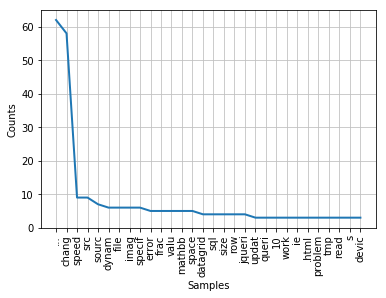

In [27]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [9]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [11]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

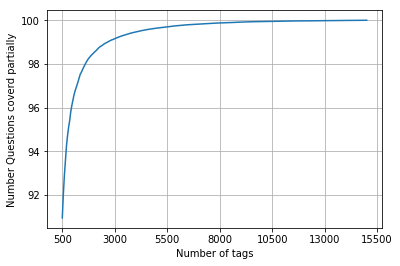

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [12]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [13]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


### Train-Test Split

In [14]:
train_datasize = 400000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [15]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [16]:
from sklearn.preprocessing import normalize

tf_idf_vect = TfidfVectorizer(min_df=0.00009,max_features=2000)
train_tfidf = tf_idf_vect.fit_transform(x_train['question'])
train_std_tfidf = normalize(train_tfidf, axis=0)
train_std_tfidf.shape

(400000, 2000)

### Multicollinearity check

In [55]:
import time
from sklearn.model_selection import cross_val_score

def Logistic_Regression(train_std_data, y_1):
    start=time.time()
    clf = OneVsRestClassifier(LogisticRegression(),n_jobs=-1)    
    clf.fit(train_std_data, y_1) 
    return clf

In [56]:
# Training the model before pertubation test. 
# Chose TFIDF features to check for multicollinearity.
# C=0.1 -> we have already tuned the hyperparameter for the data{randomsearchCV}.

#model=LogisticRegression(C=0.1)
#model.fit(train_std_tfidf,y_1);
#weights=grid_tfidf.classes_
#print(weights)
#np.sort(weights)

model = Logistic_Regression(train_std_tfidf,y_train)
weights = model.coef_

In [57]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

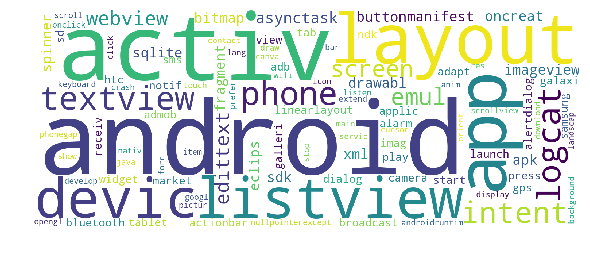

In [58]:

def show_most_informative_features(vectorizer, clf, n=100):
    text = ' '
    feature_names = vectorizer.get_feature_names()
    #print(sorted(clf.coef_[0]))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top = coefs_with_fns[:-(n + 1):-1]
    for i,(coef_1, fn_1) in enumerate(top):
        text = text + fn_1 + ' '
        #print("\t%.4f\t%-15s\t" %(coef_1, fn_1))
    plot_wordcloud(text)
        
show_most_informative_features(tf_idf_vect, model)

In [59]:
# converting data from sparse matrix to array inorder to add small value[Pertubation test].

data=train_std_tfidf
data=data.toarray()

In [60]:
# tf_idf_vect.max_features:2000 {It was defined at the time of tfidf featurization.}
# Adding small value to the data where there are nonzero's
start=time.time()

for i in range(train_std_tfidf.shape[0]):
    for j in range(tf_idf_vect.max_features):
        if data[i][j]!=0:
            data[i][j]=data[i][j]+np.random.normal(0, 0.001)
            
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

# modified_data=[data[i][j]+np.random.normal(0, 0.01) for i in range((train_std_tfidf.shape[0])) for j in range(2000) if data[i][j]!=0]

00:11:00


In [61]:
from scipy import sparse
# To convert from array to csr_matrix.
train_std_tfidf_modified = sparse.csr_matrix(data)
# train_std_tfidf_modified

In [62]:
# After adding little values again we are training the model.

model_modified = Logistic_Regression(train_std_tfidf_modified,y_train);
weights1 = model_modified.coef_
#print(weights1)
#np.sort(weights1)


In [63]:
pct_change=[(np.absolute((a - b)+0.00001/(a+0.00001)))*100 for a, b in zip(weights[::1], weights1[::1])]
print(len(pct_change))
print(type(pct_change))

500
<class 'list'>


In [64]:
pct_change1 = pct_change
pct_change1 = np.array(pct_change1).T

In [65]:
 
# print(type(pct_change1))
# #pct_change1 =(pct_change1[:][-1])
# plt.figure(figsize=(10,5))
# plt.plot((range(len(pct_change1))),list(sorted(pct_change1,reverse=False)))
# plt.xlabel("Index")
# plt.ylabel("Percentage change")
# plt.title("Elbow method")
# plt.grid()

In [66]:
from prettytable import PrettyTable  

x = PrettyTable()

x.field_names = ["Feature Index(Value)", "Feature(Key)", "Percentage weight change"]

for j in range(tf_idf_vect.max_features):
    if(pct_change[0][j]>=10): # if percentage change is greater than or equal to 'x' percentage, then print the values. 
        for key,value in tf_idf_vect.vocabulary_.items():
            if(value==j):
                x.add_row([value,key,pct_change[0][j]])
                #print("Feature:",value," -> ",key," -> ",pct_change[0][j]) 
                
print(x)

+----------------------+--------------+--------------------------+
| Feature Index(Value) | Feature(Key) | Percentage weight change |
+----------------------+--------------+--------------------------+
|         135          |   android    |    137.3706977947823     |
|         160          |     app      |    16.12964981693839     |
|         387          |     code     |    14.948210881406174    |
|         459          |    could     |    11.031288117018127    |
|         540          |    differ    |    12.88410384711924     |
|         1007         |     like     |    20.35488966215254     |
|         1017         |     list     |    10.484817271978116    |
|         1637         |    someth    |    10.514334068182244    |
|         1823         |     tri      |    14.719840048433912    |
|         1870         |     use      |    15.747501920001787    |
|         1912         |     want     |    20.239319907131982    |
|         1957         |     work     |    24.983578170354626 

### Featurizing the data - TFIDF Vectorizer (3-grams)

In [16]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:50.740560


In [17]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


### Logistic Regression(OVR)

In [18]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2511
Hamming loss  0.00270286
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3673, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2951, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43    

In [21]:
y_train

<400000x500 sparse matrix of type '<class 'numpy.int64'>'
	with 753684 stored elements in Compressed Sparse Row format>

### Logistic Regression with Grid Search

In [23]:
# OneVsRestClassifier(estimator, n_jobs=None) -> multiclass/multilabel strategy
# This strategy consists in fitting one classifier per class.
# In the multilabel learning literature, OvR is also known as the binary relevance method.

# GridSearch -> Search over parameter values for an estimator


start = datetime.now()

cv_scores = []
tuned_parameters = [{'estimator__C': [0.01,0.1,10,100]}]

# k = StratifiedKFold(n_splits=3)
# n_jobs = -1 -> Using all the processors to compute.
# penalty -> Used to specify the norm used in the penalization [l1 or l2]

classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'),n_jobs=-1) 
grid_lr = GridSearchCV(classifier_2, tuned_parameters, scoring = 'f1_micro', cv=3)
grid_lr.fit(x_train_multilabel,y_train)

print("Best Estimator: ")
model = grid_lr.best_estimator_

print(model)

print("******"*20)

predictions_2 = grid_lr.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)




Best Estimator: 
OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)
************************************************************************************************************************
Accuracy : 0.2259
Hamming loss  0.00297488
Micro-average quality numbers
Precision: 0.6096, Recall: 0.4011, F1-measure: 0.4838
Macro-average quality numbers
Precision: 0.5015, Recall: 0.3187, F1-measure: 0.3830
             precision    recall  f1-score   support

          0       0.90      0.74      0.82      5519
          1       0.52      0.42      0.47      8190
          2       0.64      0.47      0.54      6529
          3       0.71      0.53      0.60      3231
          4       0.66      0.49      0.56      6430
          5     

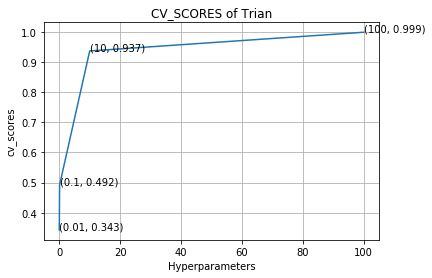

************************************************************************************************************************


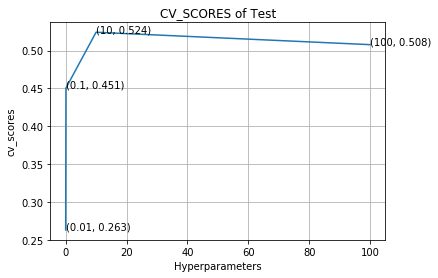

In [24]:
estimator__C = [0.01,0.1,10,100]

cv_scores = (grid_lr.cv_results_['mean_train_score'])

plt.plot(estimator__C, cv_scores)
    
for xy in zip(estimator__C, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('Hyperparameters')
plt.ylabel('cv_scores')
plt.title("CV_SCORES of Trian")
plt.grid()
plt.show()
print("******"*20)
cv_scores = (grid_lr.cv_results_['mean_test_score'])

plt.plot(estimator__C, cv_scores)
    
for xy in zip(estimator__C, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
plt.xlabel('Hyperparameters')
plt.ylabel('cv_scores')
plt.title("CV_SCORES of Test")
plt.grid()
plt.show()

### Observations:

We all know that Logistic Regression works fairly well with the text data which has higher dimensions. As it is a multi lable problem onevsrest classifier is the better choice to solve this problem. It uses one label at a time and setting the remaing to zeros. It is also called as binary relevamce method.

We used GridSearch inorder to tune the hyperparameters. It searches over specified parameter values for an estimator.We set the classifier and passed it through grid search along with some parameters to tune and setting scoring to f1_micro which is a better option for multi label classification problem.

GridSearch provides us two attributes (mean_train_score and mean_test_score) with which we can plot and find out the best parameter from the given.Crossvalidation is by default if we use gridsearch. I used 3 fold cross validation in the above code.

n_jobs -> Parameter which is very userfull inorder to run the code fast. It uses all the cores present in our system to run the program.

With the best parameter(C=10) we fitted the model and test data is applied to the model and got f1_micro of 0.48 with only 0.5M datapoints. With better tuning of hyperparameters and  taking more datapoints, we could get better results. I took only 0.5 million datapoints as I have limited computational capacity.It took nearly 8 hours for the above code to run. We also used other metrics like precision,recall,hamming loss,f1_macro,accuracy inorder to know how the model is performing.




### Linear SVM(OVR)

In [25]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'),n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.15948
Hamming loss  0.00321358
Micro-average quality numbers
Precision: 0.8305, Recall: 0.0949, F1-measure: 0.1704
Macro-average quality numbers
Precision: 0.0294, Recall: 0.0109, F1-measure: 0.0154
             precision    recall  f1-score   support

          0       0.95      0.44      0.60      5519
          1       0.52      0.16      0.25      8190
          2       0.86      0.25      0.38      6529
          3       0.77      0.27      0.40      3231
          4       0.89      0.26      0.41      6430
          5       0.82      0.23      0.35      2879
          6       0.92      0.42      0.58      5086
          7       0.91      0.46      0.61      4533
          8       0.60      0.03      0.06      3000
          9       0.78      0.32      0.45      2765
         10       0.00      0.00      0.00      3051
         11       0.00      0.00      0.00      3009
         12       0.00      0.00      0.00      2630
         13       0.00      0.00      0.00   

### Observations:

LinearSVM works good with high dimension data. SGDClassifier with loss as hinge gives us the linerSVM model. Here alpha is set to 0.001 which multiplies the regularization term to avoid overfitting. Used ovevsrest classifier as it is a bettr option for multi lable classification problem.

With the best parameter(alpha = 0.001) we fitted the model and test data is applied to the model and got f1_micro of 0.17 with 0.5M datapoints. By  tuning the hyperparmeters and taking moredatapoints we can improve the model a lot.We also used other metrics like precision,recall,hamming loss,f1_macro,accuracy inorder to know how the model is performing


### BOW(4-grams)

In [26]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000,\
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel_bow = vectorizer.fit_transform(x_train['question'])
x_test_multilabel_bow = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:11:39.360001


In [27]:
print("Dimensions of train data X:",x_train_multilabel_bow.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel_bow.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 95585) Y : (400000, 500)
Dimensions of test data X: (100000, 95585) Y: (100000, 500)


### Logistic Regreession(OVR) - (4-grams)

In [30]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', n_jobs=-1))
classifier.fit(x_train_multilabel_bow, y_train)
predictions = classifier.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21219
Hamming loss  0.00313268
Micro-average quality numbers
Precision: 0.5686, Recall: 0.4097, F1-measure: 0.4762
Macro-average quality numbers
Precision: 0.4511, Recall: 0.3346, F1-measure: 0.3806
             precision    recall  f1-score   support

          0       0.90      0.73      0.81      5519
          1       0.52      0.41      0.46      8190
          2       0.64      0.47      0.54      6529
          3       0.68      0.53      0.59      3231
          4       0.66      0.49      0.56      6430
          5       0.62      0.42      0.50      2879
          6       0.74      0.57      0.64      5086
          7       0.75      0.61      0.68      4533
          8       0.34      0.18      0.24      3000
          9       0.69      0.59      0.64      2765
         10       0.42      0.29      0.35      3051
         11       0.59      0.45      0.51      3009
         12       0.48      0.36      0.41      2630
         13       0.54      0.38      0.44   

### Observations:

As discussed above Logistic Regression works fairly well with the text data which has higher dimensions. As it is a multi lable problem onevsrest classifier is the better choice to solve this problem. It uses one label at a time and setting the remaing to zeros. It is also called as binary relevamce method.

Here I used 4grams BOW inorder to store some sequence information.

n_jobs -> Parameter which is very userfull inorder to run the code fast. It uses all the cores present in our system to run the program.

We fitted the model and test data is applied to the model and got f1_micro of 0.47 with only 0.5M datapoints. With better tuning of hyperparameters and  taking more datapoints, we could get better results. It took nearly 5 hours for the above code to run. We also used other metrics like precision,recall,hamming loss,f1_macro,accuracy inorder to know how the model is performing.




### Conclusion:

In [48]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Accuracy", "(Precision,Recall,F1_micro)", "(Precision,Recall,F1_macro)"]
x.add_row(["Tfidf (3-grams)", "Log Reg(OVR)",0.2511,(0.7172, 0.3673, 0.4858),(0.5570, 0.2951, 0.3710)])
x.add_row(["Tfidf (3-grams)", "Log Reg(Grid Search)",0.2259,(0.6096, 0.4011, 0.4838), (0.5015,0.3187,0.3830)])
x.add_row(["TFIDF(3-grams)", "Linear SVM",0.15948,(0.8305, 0.0949, 0.1704),(0.0294,0.0109,0.0154)])
x.add_row(["BOW(4-grams)", "Log Reg(OVR)",0.2121,(0.5686, 0.4097, 0.4762), (0.4511, 0.3346, 0.3802)])

print(x)


+-----------------+----------------------+----------+-----------------------------+-----------------------------+
|    Vectorizer   |        Model         | Accuracy | (Precision,Recall,F1_micro) | (Precision,Recall,F1_macro) |
+-----------------+----------------------+----------+-----------------------------+-----------------------------+
| Tfidf (3-grams) |     Log Reg(OVR)     |  0.2511  |   (0.7172, 0.3673, 0.4858)  |    (0.557, 0.2951, 0.371)   |
| Tfidf (3-grams) | Log Reg(Grid Search) |  0.2259  |   (0.6096, 0.4011, 0.4838)  |   (0.5015, 0.3187, 0.383)   |
|  TFIDF(3-grams) |      Linear SVM      | 0.15948  |   (0.8305, 0.0949, 0.1704)  |   (0.0294, 0.0109, 0.0154)  |
|   BOW(4-grams)  |     Log Reg(OVR)     |  0.2121  |   (0.5686, 0.4097, 0.4762)  |   (0.4511, 0.3346, 0.3802)  |
+-----------------+----------------------+----------+-----------------------------+-----------------------------+


From all the above models Logistic Regression using onevsrest classifier with default parameter value of 1.0 performs good than all the other models with metric f1_micro score as 0.4858. We can improve these models by hyperparameter tuning and taking large datasets.